# 3D Alternate - MLflow

In [1]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Load Data

In [2]:
from recognizer.utils.constants import ROOT_DIR, TARGET_TO_ENCODING
from recognizer.utils.utils import get_metadata_from_filename

DATASET_DIR_POSTA = ROOT_DIR / "data" / "all-20percent"

In [3]:
import os

import pandas as pd

targets = []
subjects = []
repetitions = []
files = []

for file in os.listdir(DATASET_DIR_POSTA):

    target, subject, repetition = get_metadata_from_filename(file)

    targets.append(target)
    subjects.append(subject)
    repetitions.append(repetition)
    files.append(str((DATASET_DIR_POSTA / file).resolve()))


metadata = pd.DataFrame(
    data={
        "target": targets,
        "subject": subjects,
        "repetition": repetitions,
        "file": files,
    }
)

metadata["target_encoding"] = metadata["target"].map(TARGET_TO_ENCODING)

metadata.head()

,target,subject,repetition,file,target_encoding
0,001,001,001,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
1,001,001,002,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
2,001,001,003,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
3,001,001,004,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
4,001,001,005,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0


### Train/Test split

In [4]:
import numpy as np

size = 1
replace = False
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]

testing_set = metadata.groupby(["target", "subject"], as_index=False).apply(fn)

testing_set.index = testing_set.index.droplevel(0)

training_set = metadata.loc[~metadata.index.isin(testing_set.index), :]

### Pre-processing functions

In [5]:
def transform(x):
    """Permutes the element to match the format expected by PyTorch: (C<channels>, T<frames>, H<height>, W<width>)"""
    # Transpose video from (T<frames>, H<height>, W<width>, C<channels>) to (C<channels>, T<frames>, H<height>, W<width>)
    return x.permute(3, 0, 1, 2).float()


### Parameters

In [42]:
BATCH_SIZE = 24
NUM_CLASSES = 64
NUM_FRAMES = 16
EPOCHS = 50
LR = 0.01

In [43]:
from recognizer.dataset import SampledVideoDataset

training_dataset = SampledVideoDataset(
    video_filenames=training_set["file"].values,
    labels=training_set["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)

testing_dataset = SampledVideoDataset(
    video_filenames=testing_set["file"].values,
    labels=testing_set["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)

print(f"Training/testing set: ({len(training_dataset)}, {len(testing_dataset)})")

Training/testing set: (2560, 640)


In [44]:
testing_set.groupby("target_encoding").count()

,target,subject,repetition,file
target_encoding,,,,
0,10,10,10,10
1,10,10,10,10
2,10,10,10,10
3,10,10,10,10
4,10,10,10,10
...,...,...,...,...
59,10,10,10,10
60,10,10,10,10
61,10,10,10,10


In [45]:
UNIQUE_CLASSES = metadata.target_encoding.unique()

### Data Loaders

In [46]:
import torch 
from torch import nn

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle = True)

test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle = False)

In [47]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device

'cuda'

### Model

In [48]:
from recognizer.models.alternate_3d import Alt3DCNN_v2

model = Alt3DCNN_v2(
    num_classes=NUM_CLASSES,
    num_frames=NUM_FRAMES,
    batch_size=BATCH_SIZE,
)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

loss_function = nn.CrossEntropyLoss()

In [49]:
dummy_input = torch.randn(24, 3, 16, 216, 384).cuda()

output = model(dummy_input)

print("Output shape:", output.shape)  # Should be [24, 64]

Output shape: torch.Size([24, 64])


In [50]:
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Params: {p}")

Params: 16616328


In [51]:
for n, p in model.named_parameters():
    print(f"Param: {n} | Shape: {p.shape}")

Param: conv_layer_1.0.weight | Shape: torch.Size([4, 3, 3, 3, 3])
Param: conv_layer_1.0.bias | Shape: torch.Size([4])
Param: conv_layer_2.0.weight | Shape: torch.Size([4, 4, 3, 3, 3])
Param: conv_layer_2.0.bias | Shape: torch.Size([4])
Param: fc_layer.0.weight | Shape: torch.Size([200, 82944])
Param: fc_layer.0.bias | Shape: torch.Size([200])
Param: fc_layer.3.weight | Shape: torch.Size([100, 200])
Param: fc_layer.3.bias | Shape: torch.Size([100])
Param: fc_layer.6.weight | Shape: torch.Size([64, 100])
Param: fc_layer.6.bias | Shape: torch.Size([64])


## Set Up Experiment in MLflow

In [52]:
import mlflow
import os

from mlflow.entities import Experiment
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_SERVER_URI = "http://localhost:5001"

os.environ["AWS_ACCESS_KEY_ID"] = "miniouser"
os.environ["AWS_SECRET_ACCESS_KEY"] = "miniopass"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://localhost:9000/"

mlflow.set_tracking_uri(MLFLOW_TRACKING_SERVER_URI)
mlflow_client = MlflowClient(MLFLOW_TRACKING_SERVER_URI)

In [53]:
EXPERIMENT_NAME = "3D Alternate 01"

experiment: Experiment = mlflow.set_experiment(experiment_name=EXPERIMENT_NAME)

In [54]:
RUN_NAME = "Execution 06"

run = None

matching_runs = mlflow_client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string=f"tags.mlflow.runName = '{RUN_NAME}'"
)

if len(matching_runs) > 0:
    raise Exception("Pisando run existente!!!!!")

run = mlflow_client.create_run(experiment_id=experiment.experiment_id)

mlflow_client.set_tag(run_id=run.info.run_id, key="mlflow.runName", value=RUN_NAME)

print(f"Run '{RUN_NAME}' creado con ID '{run.info.run_id}'")

Run 'Execution 06' creado con ID '59879c8236dc4d80a6aefd46ff25ccfa'


### Log Params

In [55]:
mlflow_client.log_param(run_id=run.info.run_id, key="BATCH_SIZE", value=BATCH_SIZE)
mlflow_client.log_param(run_id=run.info.run_id, key="NUM_CLASSES", value=NUM_CLASSES)
mlflow_client.log_param(run_id=run.info.run_id, key="EPOCHS", value=EPOCHS)
mlflow_client.log_param(run_id=run.info.run_id, key="NUM_FRAMES", value=NUM_FRAMES)
mlflow_client.log_param(run_id=run.info.run_id, key="LR", value=LR)

print("Params successfully logged")

Params successfully logged


In [56]:
mlflow_client.log_text(run_id=run.info.run_id, text=str(testing_set.index.values), artifact_file="testing set index.txt")

## Training

In [57]:
import subprocess

CMD = '''
on run argv
  display notification (item 2 of argv) with title (item 1 of argv) sound name "Glass"
end run
'''

def notify(title, text):
    subprocess.call(['osascript', '-e', CMD, title, text])

In [58]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

cm = None

metrics = {
    "training_loss": [],
    "testing_loss": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}

In [59]:
print(
f"""
Beginning model training with parameters:
- Epochs: {EPOCHS}
- Batch Size: {BATCH_SIZE}
"""
)

best_loss = np.inf
patience = 3
delta = 0.01
epochs_without_improvement = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} - Training phase")

    model.train()

    running_training_loss = 0.0

    for _, data in enumerate(train_loader):

        batch, labels = data[0].to(device), data[1].to(device)

        logits = model(batch)

        loss = loss_function(logits, labels)

        running_training_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_training_loss = running_training_loss / len(train_loader)
    metrics["training_loss"].append(round(average_training_loss, 2))

    print(f"    - AVG Training Loss: {average_training_loss:.2f}")

    # Evaluation
    print(f"Epoch {epoch + 1} - Evaluation phase")

    model.eval()

    all_preds = []
    all_targets = []

    running_testing_loss = 0.0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            logits = model(inputs)

            _, preds = torch.max(logits, 1)

            all_preds.append(preds.cpu())
            all_targets.append(labels.cpu())

            loss = loss_function(logits, labels)
            running_testing_loss += loss.item()

    average_testing_loss = running_testing_loss / len(test_loader)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    assert len(all_preds) == len(all_targets) == 640
    assert len(np.unique(all_targets)) == NUM_CLASSES

    unique_preds = set(all_preds.numpy())
    missing_classes = set(UNIQUE_CLASSES) - unique_preds

    if missing_classes:
        print(f"    The following classes ({len(missing_classes)}) were not predicted: {missing_classes}")

    metrics["testing_loss"].append(round(average_testing_loss, 2))
    metrics["accuracy"].append(accuracy_score(all_targets, all_preds))
    metrics["precision"].append(precision_score(all_targets, all_preds, average="macro", zero_division=0, labels=UNIQUE_CLASSES))
    metrics["recall"].append(recall_score(all_targets, all_preds, average="macro", zero_division=0, labels=UNIQUE_CLASSES))
    metrics["f1"].append(f1_score(all_targets, all_preds, average="macro", zero_division=0, labels=UNIQUE_CLASSES))

    for metric in metrics.keys():
        mlflow_client.log_metric(
            run_id=run.info.run_id,
            key=metric,
            value=metrics[metric][epoch],
            step=epoch,
        )
    
    print(f"""
    - Testing Loss: {metrics['testing_loss'][-1]}
    - Accuracy  : {metrics['accuracy'][-1]}
    - Precision : {metrics['precision'][-1]}
    - Recall    : {metrics['recall'][-1]}
    - F1        : {metrics['f1'][-1]}
    """)

    if average_testing_loss < best_loss - delta:
        best_loss = average_testing_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. Testing loss is not improving!")
        break

    if epoch == EPOCHS - 1:
        cm = confusion_matrix(all_targets, all_preds)



Beginning model training with parameters:
- Epochs: 50
- Batch Size: 24

Epoch 1 - Training phase


    - AVG Training Loss: 5.78
Epoch 1 - Evaluation phase
    The following classes (63) were not predicted: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63}

    - Testing Loss: 4.16
    - Accuracy  : 0.015625
    - Precision : 0.000244140625
    - Recall    : 0.015625
    - F1        : 0.0004807692307692308
    
Epoch 2 - Training phase
    - AVG Training Loss: 4.17
Epoch 2 - Evaluation phase
    The following classes (63) were not predicted: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63}

    - Testing Loss: 4.16
    - Accuracy  : 0.015625
    - Precision : 0.000244140625
    - Recall    : 0.015625
  

## Evaluation

### Confusion Matrix

In [60]:
cm = confusion_matrix(all_targets, all_preds)

<AxesSubplot: >

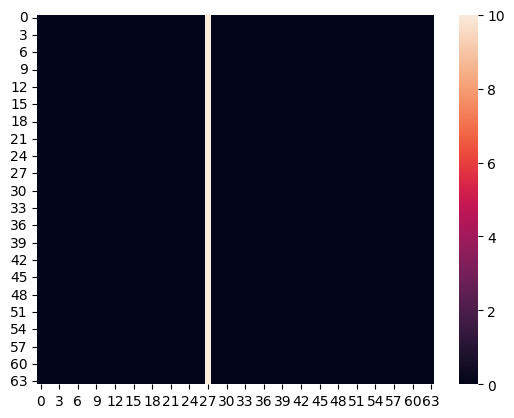

In [61]:
import seaborn as sns

sns.heatmap(data=cm)

### Accuracy/Recall/Precision

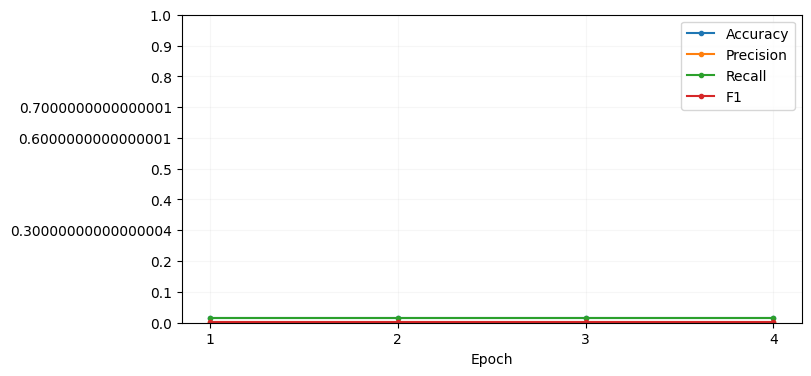

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(metrics["accuracy"], label="Accuracy", marker=".")
ax.plot(metrics["precision"], label="Precision", marker=".")
ax.plot(metrics["recall"], label="Recall", marker=".")
ax.plot(metrics["f1"], label="F1", marker=".")

ax.set_xticks(range(0, epoch+1))
ax.set_xticklabels(range(1, epoch+2))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels(np.arange(0, 1.1, 0.1))
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(alpha=0.1)
plt.show()

### Loss

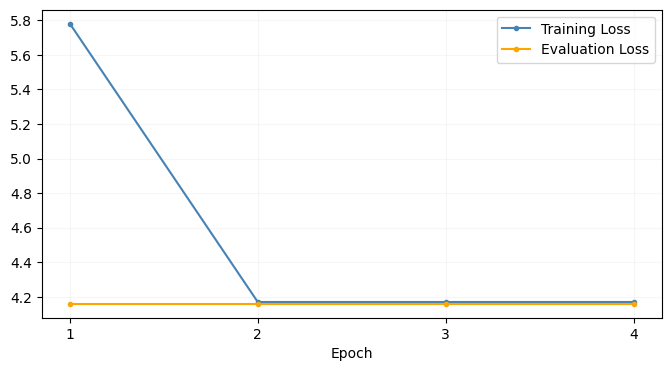

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(metrics["training_loss"], label="Training Loss", marker=".", color="steelblue")
ax.plot(metrics["testing_loss"], label="Evaluation Loss", marker=".", color="orange")

ax.set_xticks(range(0, epoch+1))
ax.set_xticklabels(range(1, epoch+2))
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(alpha=0.1)
plt.show()

## Save model

In [64]:
import copy
from recognizer.utils.constants import ROOT_DIR

MODELS_DIR = ROOT_DIR / "models"

MODEL_PATH = MODELS_DIR / f"{EXPERIMENT_NAME}_{RUN_NAME}.pth"

if MODEL_PATH.exists():
        raise Exception("El modelo ya existe!!!!")

with open(MODEL_PATH, "w") as f:
        f.write("")

torch.save(copy.deepcopy(model.state_dict()), f=MODEL_PATH)

In [65]:
mlflow_client.log_artifact(
    run_id=run.info.run_id,
    local_path=str(MODEL_PATH),
    artifact_path="",
)

In [66]:
all_targets

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 22, 22, 22, 22, 

In [67]:
all_preds

tensor([27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 

In [68]:
import tempfile
import os

# Save the arrays to temporary npy files
with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as f:
    np.save(f, all_targets)
    ground_truth_path = f.name

    f.close()

    # Log the files to MLflow
    mlflow_client.log_artifact(
        run_id=run.info.run_id,
        local_path=ground_truth_path, 
        artifact_path="ground_truth"
    )


with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as f:
    np.save(f, all_preds)
    predictions_path = f.name

    f.close()

    mlflow_client.log_artifact(
        run_id=run.info.run_id,
        local_path=predictions_path, 
        artifact_path="predictions"
    )

In [69]:
mlflow.end_run()

## Clasificación manual

In [70]:
import random

idx = random.randint(0, BATCH_SIZE)

batch, klasses = next(iter(test_loader))

sign_video = batch[idx]

klass = klasses[idx]

IndexError: index 24 is out of bounds for dimension 0 with size 24

In [ ]:
sign_video = sign_video.unsqueeze(0)
sign_video.shape

torch.Size([1, 3, 16, 216, 384])

In [ ]:
model.eval()

logits = model(sign_video.to(device))

In [ ]:
logits

tensor([[-0.0009,  0.0228, -0.0198, -0.0433, -0.0161, -0.0101,  0.0212, -0.0134,
         -0.0178, -0.0347, -0.0092, -0.0056,  0.0218, -0.0063, -0.0018,  0.0047,
         -0.0430, -0.0328,  0.0023, -0.0151, -0.0067,  0.0030, -0.0031, -0.0133,
          0.0324,  0.0087, -0.0019, -0.0022,  0.0114,  0.0021,  0.0314,  0.0014,
         -0.0284,  0.0032, -0.0117, -0.0071, -0.0345, -0.0039, -0.0068,  0.0298,
         -0.0302, -0.0015, -0.0169, -0.0348, -0.0060,  0.0022, -0.0074, -0.0409,
         -0.0099, -0.0062,  0.0132, -0.0095,  0.0151,  0.0133, -0.0203, -0.0093,
          0.0230, -0.0261, -0.0060, -0.0303, -0.0085,  0.0047, -0.0009,  0.0322]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
from torch import nn

pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Ground Truth: {klass}. Predicted class: {y_pred}")

Ground Truth: 2. Predicted class: tensor([24], device='cuda:0')
